# Описание набора данных

В файлах user_step_action.csv, user_step_status.csv хранится информация о действиях студентов на онлайн-курсе.

Файл user_step_action.csv:

Признак  | Описание
-------------------|--------------------
step_id       | ID степа на онлайн-курсе
timestamp       | Временная отметка действия на степе
action       | Действие на степе
user_id       | ID пользователя

Файл user_step_status.csv:

Признак  | Описание
-------------------|--------------------
step_id       | ID степа на онлайн-курсе
timestamp       | Временная отметка действия на степе
submission_status       | Статус выполнения задания на степе
user_id       | ID пользователя

# Загрузка и предварительная обработка данных

Данные представлены в видел лог-файла действий пользователей на курсе.

Необходимо отобрать действия пользователя за первые два дня, а также выделить признаки для каждого пользователя. В качестве признаков будут выделены следующие характеристики:


1.   Количество уникальных дней
2.   Количество верных решений
3.   Количество неверных решений
4.   Количество уникальных степов
5.   Доля верных решений
6.   Суммарное количество действий на курсе




На следующем этапе подготовим данные для тренировки модели.

Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics

Загрузка данных

In [ ]:
user_step_action = pd.read_csv('user_step_action.csv')
user_step_action

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


In [ ]:
user_step_status = pd.read_csv('user_step_status.csv')
user_step_status

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


Начнем преобразование данных для извлечения характеритик для обучения модели.

Для начала отберем для каждого пользователя действия за первые два дня.

In [ ]:
user_timestamp_min = user_step_action.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename(columns={'timestamp': 'first_timestamp'})
user_learning_period = (user_timestamp_min['first_timestamp'] + 2 * 24 * 60 * 60)
user_timestamp_min['user_learning_period'] = user_learning_period
user_step_action = user_step_action.merge(user_timestamp_min[['user_id', 'user_learning_period']], how='outer')
action_data_train = user_step_action[user_step_action['timestamp'] <= user_step_action['user_learning_period']]


In [ ]:
user_timestamp_min = user_step_status.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename(columns={'timestamp': 'first_timestamp'})
user_learning_period = (user_timestamp_min['first_timestamp'] + 2 * 24 * 60 * 60)
user_timestamp_min['user_learning_period'] = user_learning_period
user_step_status = user_step_status.merge(user_timestamp_min[['user_id', 'user_learning_period']], how='outer')
status_data_train = user_step_status[user_step_status['timestamp'] <= user_step_status['user_learning_period']]

В качества первой характеристики выделим количество унакальных дней, в которые пользователь совершал действия на курсе.

In [ ]:
date = pd.to_datetime(action_data_train.timestamp, unit='s')
action_data_train = action_data_train.copy()
action_data_train.loc[:, 'day'] = date.dt.date
x_data_train = action_data_train.groupby('user_id')['day'].nunique().to_frame().reset_index()
x_data_train

,user_id,day
0,1,1
1,2,1
2,3,1
3,5,1
4,7,1
...,...,...
19229,26790,1
19230,26793,1
19231,26794,2
19232,26797,1


В качестве второй и третий характеристик выделим количество верных и неверных решений задач на курсе.

In [ ]:
user_correct_and_uncorrect = status_data_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()
x_data_train = x_data_train.merge(user_correct_and_uncorrect, on='user_id', how='outer')
x_data_train

,user_id,day,correct,wrong
0,1,1,NaN,NaN
1,2,1,2.0,0.0
2,3,1,4.0,4.0
3,5,1,2.0,2.0
4,7,1,NaN,NaN
...,...,...,...,...
19229,26790,1,1.0,0.0
19230,26793,1,NaN,NaN
19231,26794,2,24.0,7.0
19232,26797,1,2.0,0.0


В качестве четвертой характеристики выделим количество уникальных степов, с которыми совершал действия пользователь на курсе.

In [ ]:
attempts = status_data_train.groupby('user_id')['step_id'].nunique().to_frame().reset_index()
attempts = attempts.rename(columns={'step_id': 'steps_attempts'})
x_data_train = x_data_train.merge(attempts, on='user_id', how='outer')
x_data_train = x_data_train.rename(columns={'day': 'days'})
x_data_train

,user_id,days,correct,wrong,steps_attempts
0,1,1,NaN,NaN,NaN
1,2,1,2.0,0.0,2.0
2,3,1,4.0,4.0,4.0
3,5,1,2.0,2.0,2.0
4,7,1,NaN,NaN,NaN
...,...,...,...,...,...
19229,26790,1,1.0,0.0,1.0
19230,26793,1,NaN,NaN,NaN
19231,26794,2,24.0,7.0,22.0
19232,26797,1,2.0,0.0,2.0


В качестве пятой характеристики выделим долю верных решений.

In [ ]:
x_data_train['right_percentage'] = x_data_train['correct'] / (x_data_train['correct'] + x_data_train['wrong'])
x_data_train

,user_id,days,correct,wrong,steps_attempts,right_percentage
0,1,1,NaN,NaN,NaN,NaN
1,2,1,2.0,0.0,2.0,1.000000
2,3,1,4.0,4.0,4.0,0.500000
3,5,1,2.0,2.0,2.0,0.500000
4,7,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
19229,26790,1,1.0,0.0,1.0,1.000000
19230,26793,1,NaN,NaN,NaN,NaN
19231,26794,2,24.0,7.0,22.0,0.774194
19232,26797,1,2.0,0.0,2.0,1.000000


В качестве шестой характеристики выделим суммарное количесвто действий пользователя на курсе.

In [ ]:
user_action = action_data_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
x_data_train = x_data_train.merge(user_action, on='user_id', how='outer')
x_data_train['sum_event'] = x_data_train['discovered'] + x_data_train['discovered'] + x_data_train['passed'] + x_data_train['started_attempt'] + x_data_train['viewed']
x_data_train.drop(['discovered', 'passed', 'viewed', 'started_attempt'], axis=1, inplace=True)
x_data_train

,user_id,days,correct,wrong,steps_attempts,right_percentage,sum_event
0,1,1,NaN,NaN,NaN,NaN,3
1,2,1,2.0,0.0,2.0,1.000000,38
2,3,1,4.0,4.0,4.0,0.500000,69
3,5,1,2.0,2.0,2.0,0.500000,4
4,7,1,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...
19229,26790,1,1.0,0.0,1.0,1.000000,8
19230,26793,1,NaN,NaN,NaN,NaN,4
19231,26794,2,24.0,7.0,22.0,0.774194,264
19232,26797,1,2.0,0.0,2.0,1.000000,42


Объеденим все действия в один класс Preparation.

Описание методов класса Preparation:

*   init: конструктор класса, где осуществляется загрузка данных и параметров отвечающих за признаки окончания курса (количество дней по которым проводится тренировка модели, количество баллов для успешного окончания курса, максимальная временная отметка в датасете)
*   get_timestamp: метод для получения timestamp по количеству дней
*   get_dataset: подготовка датасета, где осуществляется отбор действий пользователей за указанный период. Далее для каждого пользователя осуществляется определение количества уникальных дней, количества верных и неверных решений, количества уникальных степов, доля верных решений, суммарного количества действий пользователя.





In [ ]:
class Preparation():

    def __init__(self, path_1, path_2, period, point_finish):
        self.user_step_action = pd.read_csv(path_1)
        self.user_step_status = pd.read_csv(path_2)
        self.learning_period = self.get_timestamp(period)
        self.point_finish = point_finish
        self.dataset = None

    def get_timestamp(self, day):
        return (day * 24 * 60 * 60)

    def get_dataset(self):

        #Отбор действий за период
        user_timestamp_min = self.user_step_action.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename(columns={'timestamp': 'first_timestamp'})
        user_learning_period = (user_timestamp_min['first_timestamp'] + self.learning_period)
        user_timestamp_min['user_learning_period'] = user_learning_period
        self.user_step_action = self.user_step_action.merge(user_timestamp_min[['user_id', 'user_learning_period']], how='outer')
        action_data_train = self.user_step_action[self.user_step_action['timestamp'] <= self.user_step_action['user_learning_period']]

        user_timestamp_min = self.user_step_status.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename(columns={'timestamp': 'first_timestamp'})
        user_learning_period = (user_timestamp_min['first_timestamp'] + self.learning_period)
        user_timestamp_min['user_learning_period'] = user_learning_period
        self.user_step_status = self.user_step_status.merge(user_timestamp_min[['user_id', 'user_learning_period']], how='outer')
        status_data_train = self.user_step_status[self.user_step_status['timestamp'] <= self.user_step_status['user_learning_period']]

        #Количество уникальных дней
        date = pd.to_datetime(action_data_train.timestamp, unit='s')
        action_data_train = action_data_train.copy()
        action_data_train.loc[:, 'day'] = date.dt.date
        x_data_train = action_data_train.groupby('user_id')['day'].nunique().to_frame().reset_index()

        #Колличество верных и неверных решений
        user_correct_and_uncorrect = status_data_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()
        x_data_train = x_data_train.merge(user_correct_and_uncorrect, on='user_id', how='outer')

        #Количество уникальных степов пользователя
        attempts = status_data_train.groupby('user_id')['step_id'].nunique().to_frame().reset_index()
        attempts = attempts.rename(columns={'step_id': 'steps_attempts'})
        x_data_train = x_data_train.merge(attempts, on='user_id', how='outer')
        x_data_train = x_data_train.rename(columns={'day': 'days'})

        #Доля верных решений
        x_data_train['right_percentage'] = x_data_train['correct'] / (x_data_train['correct'] + x_data_train['wrong'])

        #Действия пользователя на курсе
        user_action = action_data_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
        x_data_train = x_data_train.merge(user_action, on='user_id', how='outer')
        x_data_train['sum_event'] = x_data_train['discovered'] + x_data_train['discovered'] + x_data_train['passed'] + x_data_train['started_attempt'] + x_data_train['viewed']
        x_data_train.drop(['discovered', 'passed', 'viewed', 'started_attempt'], axis=1, inplace=True)
        self.dataset = x_data_train.copy()

        self.dataset = self.dataset.set_index(x_data_train['user_id'])
        self.dataset = self.dataset.drop('user_id', axis=1)

Ниже представленны подготовленные данные при условии, что для успешного окончания курса по условию нужно 50 баллов.

In [ ]:
preparation = Preparation('user_step_action.csv', 'user_step_status.csv', 2, 50)
preparation.get_dataset()
preparation.dataset

,days,correct,wrong,steps_attempts,right_percentage,sum_event
user_id,,,,,,
1,1,NaN,NaN,NaN,NaN,3
2,1,2.0,0.0,2.0,1.000000,38
3,1,4.0,4.0,4.0,0.500000,69
5,1,2.0,2.0,2.0,0.500000,4
7,1,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...
26790,1,1.0,0.0,1.0,1.000000,8
26793,1,NaN,NaN,NaN,NaN,4
26794,2,24.0,7.0,22.0,0.774194,264


Для разметки датасета на прошедших и не прошедших курс пользователей необходимо определить условие, при котором пользователь в тренировочном датасете будет считаться прошедшем курс.

Пользователь будет считаться прошедшем курс если он набрал необходимое количество баллов или перерыв в прохождении курса не превышает определенного значения.

Определим временной период, при привешении которого прервавший прохождение курс пользователь будет считаться незакончившим курс.

Рассмотрим распредление перерывов в прохождении курса у пользователей.

<Axes: >

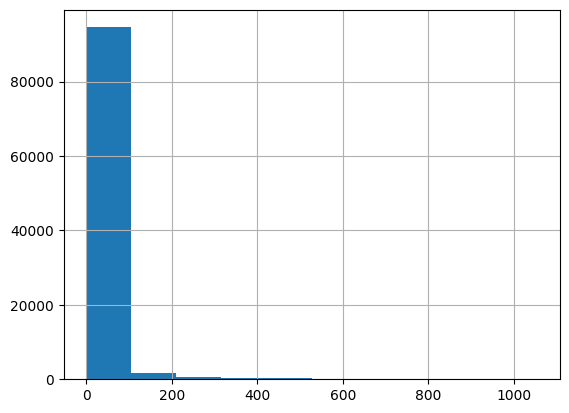

In [ ]:
date = pd.to_datetime(user_step_action.timestamp, unit='s')
event_day = user_step_action.copy()
event_day.loc[:, 'day'] = date.dt.date
user_step_action_day = event_day[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id','day'])
breaks_array = np.concatenate(user_step_action_day.groupby('user_id')['timestamp'].apply(list).apply(np.diff).values, axis=0) / (24 * 60 * 60)
pd.Series(breaks_array).hist()

Из графика видно, что большинство перерывовов укладывается в диапазон от 0 до 100 дней.

Далее найдем 0.95 квантиль для определения точного порогового значения.

In [ ]:
pd.Series(breaks_array).quantile(0.95)

59.760440972222156

В итоге получаем, что пороговым значением перерыва в прохождении курса будем считать 60 дней.

Далее найдем максимальный timestamp для рассчета перерывов пользователь с момента их последнего действия на курсе.

In [ ]:
max_timestamp = user_step_action['timestamp'].max()
max_timestamp

1526772811

Разметим датасет на тех пользователей, которые по нашим статистическим данным закончат курс и на тех, кто курс не закончит.

Для этого удалим из списка тех, кто не набрал необходимое количество баллов за курс(50) и в тоже время перерыв этого пользователя в прохождении курса не превышает 60 дней. Мы убираем этих пользователей из рассмотрения, так как мы точно не можем сказать закончат ли они курс или нет.

Тех пользователей, которые набрали 50 баллов мы будем определять как тех, кто курс прошел, а тех пользователей, которые не набрали 50 баллов и перерыв в прохождении курса больше 60 дней мы определим как тех, кто курс не закончил.

In [ ]:
point_finish = 50
user_data = user_step_action.groupby('user_id', as_index=False).agg({'timestamp': 'max'})
user_data = user_data.rename(columns={'timestamp': 'last_action'})
user_data['user_time_drop'] = (max_timestamp - user_data.last_action) > 60 * 24 * 60 * 60
user_data = user_data.merge(user_step_status.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index(), on='user_id', how='outer')
user_data = user_data.fillna(0)
user_data = user_data.merge(user_step_action.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index(), on='user_id', how='outer')
user_data['finished'] = user_data.passed > point_finish
preparation.dataset = preparation.dataset.merge(user_data[['user_id', 'finished', 'user_time_drop']], on='user_id', how='outer')
preparation.dataset = preparation.dataset[~((preparation.dataset['finished'] == False) & (preparation.dataset['user_time_drop'] == False))]
dataset = preparation.dataset.copy()
dataset['Finish'] = (dataset['finished']).map(int)
dataset = dataset.set_index(dataset['user_id'])
dataset = dataset.drop('user_id', axis=1)
indexes = dataset.index
dataset

,days,correct,wrong,steps_attempts,right_percentage,sum_event,finished,user_time_drop,Finish
user_id,,,,,,,,,
1,1,NaN,NaN,NaN,NaN,3,False,True,0
2,1,2.0,0.0,2.0,1.000000,38,False,True,0
3,1,4.0,4.0,4.0,0.500000,69,True,True,1
5,1,2.0,2.0,2.0,0.500000,4,False,True,0
8,1,9.0,21.0,11.0,0.300000,493,True,True,1
...,...,...,...,...,...,...,...,...,...
26790,1,1.0,0.0,1.0,1.000000,8,False,True,0
26793,1,NaN,NaN,NaN,NaN,4,False,True,0
26794,2,24.0,7.0,22.0,0.774194,264,True,True,1


Удалим лишние колонки.

In [ ]:
dataset = dataset.drop(['finished',	'user_time_drop'], axis=1)

Далее проверим данные на выбросы.

<Axes: >

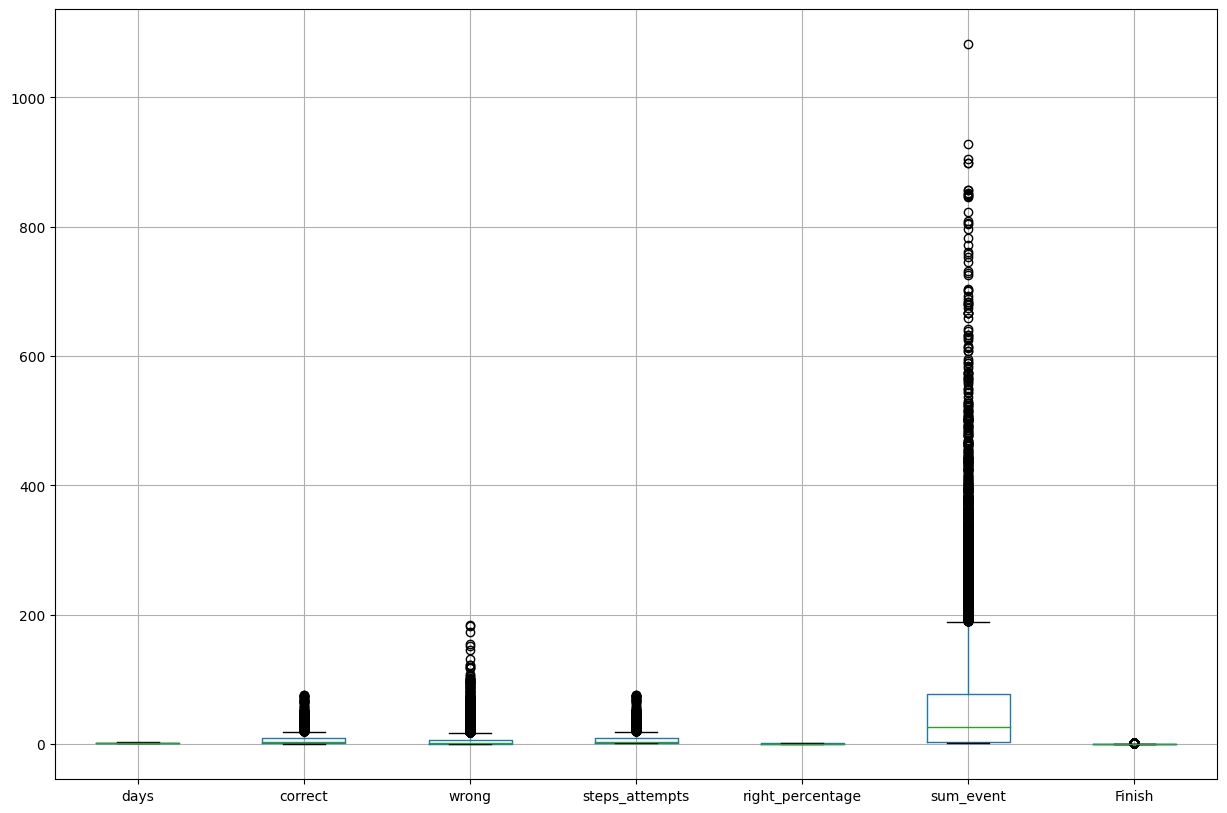

In [ ]:
dataset.boxplot(figsize=(15,10))

Как мы видим у нас присутствует достаточно большое количество выбросов.

Рассмотрим распределение в датасете на прошедших и не прошедших курс.

array([[<Axes: title={'center': 'Finish'}>]], dtype=object)

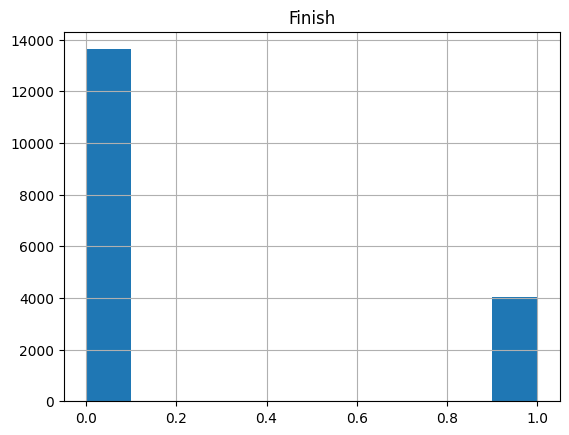

In [ ]:
dataset.hist(column='Finish')

По данной гистограмме мы видим, что датасет не симметричен, поэтому проверим выбросы по группам прошедших и не прошедших курс, так как действия пользоваетелей по данным группам на курсе могут сильно отличаться.

Проверим на выбросы группу не прошедших курс с помощью ящика с усами(boxplot).

<Axes: >

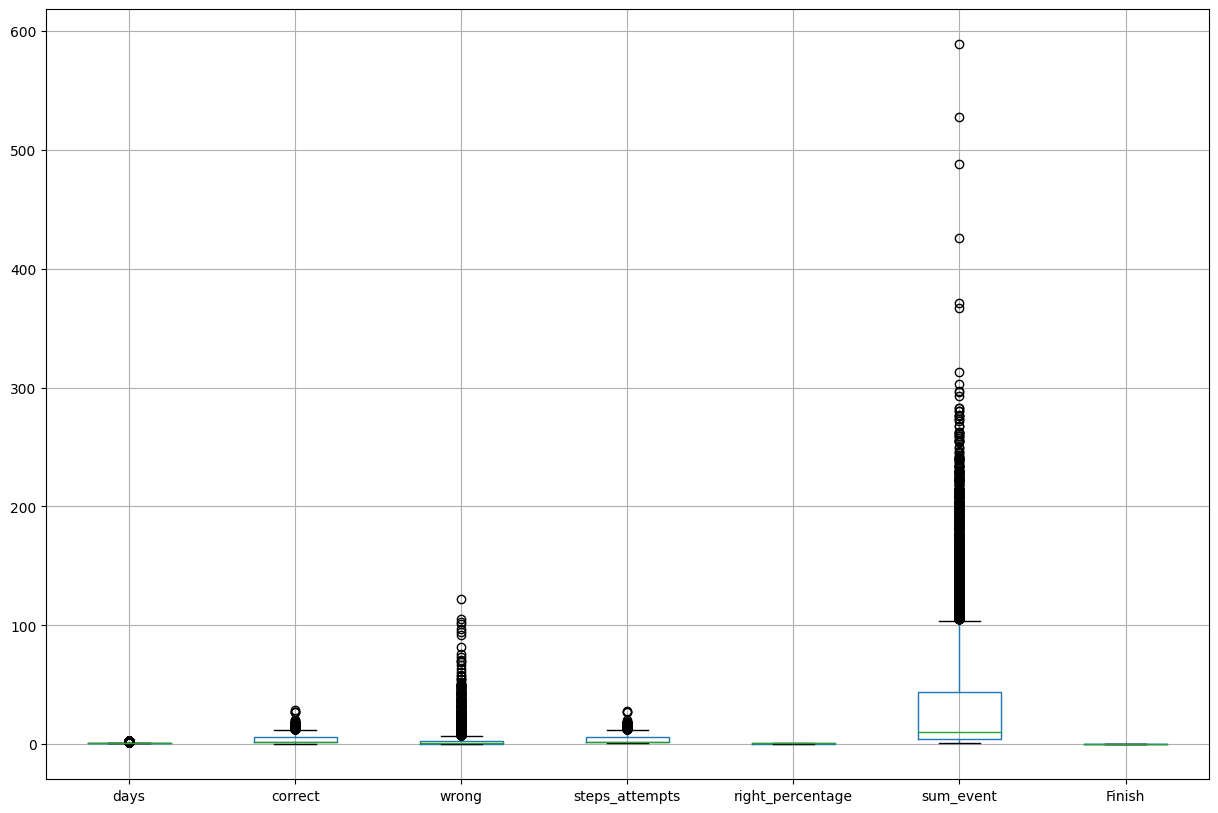

In [ ]:
dataset[dataset['Finish']==0].boxplot(figsize=(15,10))

Как мы видим, выбросы в данной группе присутствуют в столбцах correct, wrong, steps_attempts, sum_events.

Далее проверим на выбросы группу прошедших курс.

<Axes: >

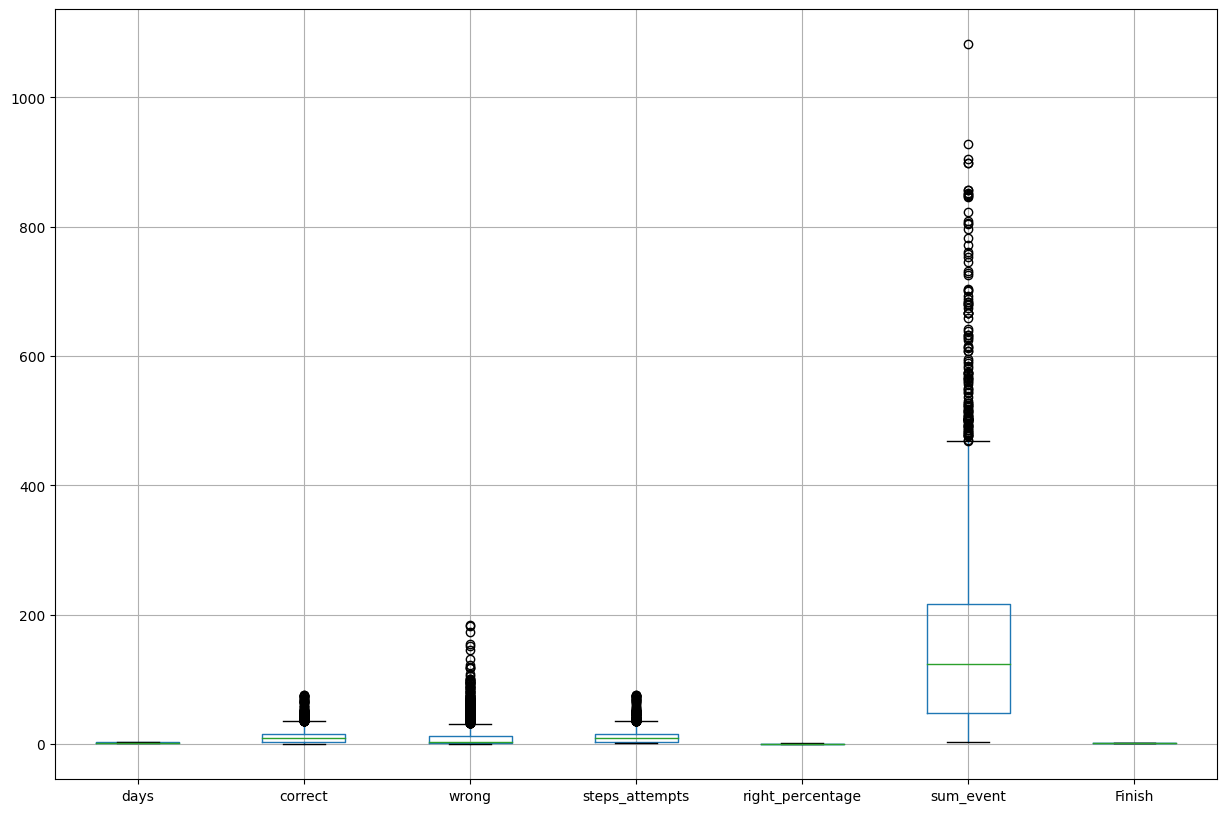

In [ ]:
dataset[dataset['Finish']==1].boxplot(figsize=(15,10))

И в группе прошедших значения также мы видим выбросы также в стобцах correct, wrong, steps_attempts, sum_events.

Для обработки выбросов применим фильтр Хэмпеля, который заменяет на nan значения, у которых разница с медианой больше, чем три медиальных значения.

In [ ]:
def hampel(vals_orig):
    vals = vals_orig.copy()
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = 3 * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return(vals)

In [ ]:
dataset.correct = hampel(dataset.correct)
dataset.wrong = hampel(dataset.wrong)
dataset.steps_attempts = hampel(dataset.steps_attempts)
dataset.sum_event = hampel(dataset.sum_event)

Далее проверим данные на пропущенные значения.

In [ ]:
dataset.isnull().sum()

days                    0
correct              9900
wrong               11517
steps_attempts       9887
right_percentage     8467
sum_event            4025
Finish                  0
dtype: int64

Как мы видим у нас есть достаточно много пропущенных значений в некоторых признаках.

Обработаем и заполним данные пропущенные значения.

Для этого используем алгоритм k-ближайших соседий.

На первом этапе стандартизируем данные.

In [ ]:
fill_knn = dataset.copy()
scaler = StandardScaler()
fill_knn = pd.DataFrame(scaler.fit_transform(fill_knn), columns = fill_knn.columns)
fill_knn

,days,correct,wrong,steps_attempts,right_percentage,sum_event,Finish
0,-0.555475,NaN,NaN,NaN,NaN,-0.832888,-0.545521
1,-0.555475,-0.698534,-0.712936,-0.728067,1.001353,0.702290,-0.545521
2,-0.555475,-0.125100,2.458870,-0.156323,-0.787055,2.062020,1.833111
3,-0.555475,-0.698534,0.872967,-0.728067,-0.787055,-0.789026,-0.545521
4,-0.555475,1.308485,NaN,1.844778,-1.502418,NaN,1.833111
...,...,...,...,...,...,...,...
17676,-0.555475,-0.985251,-0.712936,-1.013938,1.001353,-0.613577,-0.545521
17677,-0.555475,NaN,NaN,NaN,NaN,-0.789026,-0.545521
17678,1.026827,NaN,NaN,NaN,0.193685,NaN,1.833111
17679,-0.555475,-0.698534,-0.712936,-0.728067,1.001353,0.877739,-0.545521


Далее заполним пропуски по 5 ближайшим соседям.

In [ ]:
inputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
fill_knn = pd.DataFrame(inputer.fit_transform(fill_knn), columns =  fill_knn.columns)
fill_knn.isnull().sum()

days                0
correct             0
wrong               0
steps_attempts      0
right_percentage    0
sum_event           0
Finish              0
dtype: int64

Возвращаем исходный формат данных и сохраним файл в csv.

In [ ]:
fill_knn = pd.DataFrame(scaler.inverse_transform(fill_knn), columns = fill_knn.columns)
dataset = fill_knn.copy()
dataset['days'] = dataset['days'].map(int)
dataset['correct'] = dataset['correct'].map(int)
dataset['wrong'] = dataset['wrong'].map(int)
dataset['steps_attempts'] = dataset['steps_attempts'].map(int)
dataset['sum_event'] = dataset['sum_event'].map(int)
dataset['Finish'] = dataset['Finish'].map(int)
dataset.to_csv('train_dataset.csv')
dataset

,days,correct,wrong,steps_attempts,right_percentage,sum_event,Finish
0,1,7,1,9,0.357436,3,0
1,1,2,0,2,1.000000,38,0
2,1,4,4,4,0.500000,69,1
3,1,2,2,2,0.500000,4,0
4,1,9,4,11,0.300000,25,1
...,...,...,...,...,...,...,...
17676,1,1,0,1,1.000000,7,0
17677,1,7,2,8,0.650000,4,0
17678,2,7,2,7,0.774194,57,1
17679,1,2,0,2,1.000000,42,0


Получаем итоговый датасет для обучения модели.

In [ ]:
dataset = dataset.set_index(indexes)
dataset

,days,correct,wrong,steps_attempts,right_percentage,sum_event,Finish
user_id,,,,,,,
1,1,7,1,9,0.357436,3,0
2,1,2,0,2,1.000000,38,0
3,1,4,4,4,0.500000,69,1
5,1,2,2,2,0.500000,4,0
8,1,9,4,11,0.300000,25,1
...,...,...,...,...,...,...,...
26790,1,1,0,1,1.000000,7,0
26793,1,7,2,8,0.650000,4,0
26794,2,7,2,7,0.774194,57,1


# Постановка задачи и построение модели

Наша задача - определить закончит ли пользователь онлайн курс по данным о его первых двух днях на курсе.

Перед нами стоит задача классификации, где нам нужно предсказать метку класса:

*   1 - закончит курс
*   0 - не закончит курс

Для этого рассмотрим и протестируем алгоритмы классификации: алгоритм k-ближайших соседей, Решающее дерево, Наивный Байесовский классификатор.

Также реализуем ансамбль алгоритмов, где на первом уровне будет три алгоритма: алгоритм k-ближайших соседей, решающее дерево, наивный Байесовский классификатор. На втором уровне будет алгоритм который нужно будет подобрать по качеству классификации, и он будет по предсказаниям алгоритмов первого уровня предсказывать итоговую метку класса.

При подборе параметров будем максимизировать ROC-AUC-значение,
так как для нас важно определения обоих классов, а дисбаланс классов не такой большой чтобы эту метрику нельзя было использовать.
Поэтому для максимизации используем ROC-AUC-значение.
Также будет использоваться кросс-валидация для избежания переобучения.

И в конце выберем алогоритм по наибольшему ROC-AUC-значению.

На первом этапе подберем параметры для алгоритмов классификации.

Стандартизируем данные и разделим данные на тренировочную и тестовую выборки.

In [ ]:
X = dataset.copy()
indexes = X.index
y = X['Finish']
X.drop(['Finish'], axis=1, inplace=True)
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
scaled = scaler.transform(X)
X_scaled = pd.DataFrame(scaled, columns=X.columns)
X_scaled = X_scaled.set_index(indexes)
X_scaled

,days,correct,wrong,steps_attempts,right_percentage,sum_event
user_id,,,,,,
1,-0.555475,0.311347,-0.559925,0.791370,-1.338500,-0.988033
2,-0.555475,-1.385296,-1.378923,-1.478883,1.510018,0.454630
3,-0.555475,-0.706639,1.897067,-0.830239,-0.706507,1.732417
5,-0.555475,-1.385296,0.259072,-1.478883,-0.706507,-0.946814
8,-0.555475,0.990004,1.897067,1.440014,-1.593117,-0.081216
...,...,...,...,...,...,...
26790,-0.555475,-1.724624,-1.378923,-1.803205,1.510018,-0.823157
26793,-0.555475,0.311347,0.259072,0.467049,-0.041549,-0.946814
26794,1.026827,0.311347,0.259072,0.142727,0.509007,1.237790


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

Реализуем функция для построения ROC-кривой

In [ ]:
def roc_auc(model, X_test, y_test):
  y_scores = model.predict_proba(X_test)
  fpr, tpr, thresh = roc_curve(y_test, y_scores[:,1], pos_label = 1)
  roc_auc = metrics.auc(fpr, tpr)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


Далее подберем параметры для алгоритма k-ближайших соседей. А также определим точность и ROC-AUC-значение.

In [ ]:
clf_knn = KNeighborsClassifier()
knn_params = {'n_neighbors': range(1, 30), 'weights': ['uniform', 'distance'], 'p': [1,2,3], 'metric': ['euclidean', 'l1', 'l2', 'manhattan']}
gsCV_clf_knn = GridSearchCV(clf_knn, knn_params, scoring='roc_auc', cv=5)
gsCV_clf_knn.fit(X_train, y_train)
print('Параметры алгоритма knn', gsCV_clf_knn.best_params_)
print('Точность предсказания:', accuracy_score(y_test, gsCV_clf_knn.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, gsCV_clf_knn.predict(X_test)))

Параметры алгоритма knn {'metric': 'l1', 'n_neighbors': 26, 'p': 1, 'weights': 'distance'}
Точность предсказания: 0.9078314956177551
ROC-AUC: 0.8327956663376735


Построим ROC-кривую для алгоритма k-ближайших соседей с найденными оптимальными параметрами.

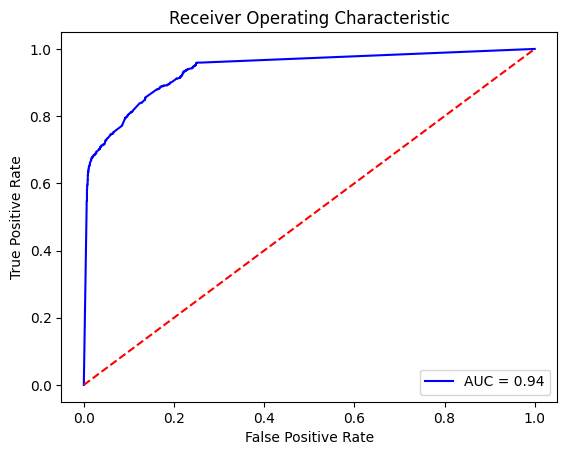

In [ ]:
clf_knn = KNeighborsClassifier(metric='l1', n_neighbors=26, p=1, weights='distance')
clf_knn.fit(X_train, y_train)
roc_auc(clf_knn, X_test, y_test)

Подберем параметры для алгоритма решающего дерева. А также определим точность и ROC-AUC-значение.

In [ ]:
clf_tree = tree.DecisionTreeClassifier()
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 23), 'min_samples_split': range(2,20,3), 'min_samples_leaf': range(1,51,3)}
gsCV_clf_tree = GridSearchCV(clf_tree, tree_params, scoring='roc_auc', cv=5)
gsCV_clf_tree.fit(X_train, y_train)
print('Параметры дерева решений:', gsCV_clf_tree.best_params_)
print('Точность предсказания:', accuracy_score(y_test, gsCV_clf_tree.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, gsCV_clf_tree.predict(X_test)))

Параметры дерева решений: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 16, 'min_samples_split': 11}
Точность предсказания: 0.9013288097257562
ROC-AUC: 0.8199149533242929


Построим ROC-кривую для алгоритма решающего дерева с найденными оптимальными параметрами.

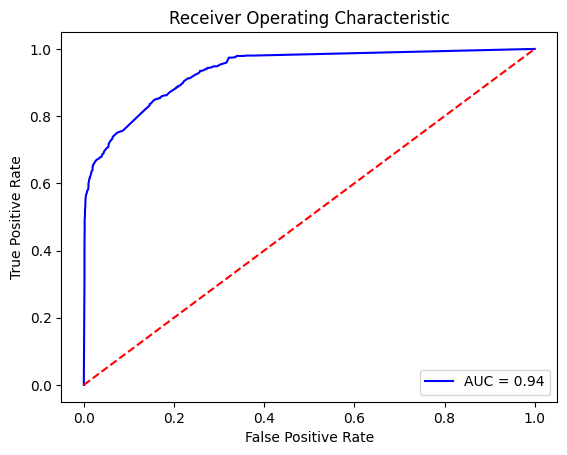

In [ ]:
clf_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=12, min_samples_leaf=16, min_samples_split=11)
clf_tree.fit(X_train, y_train)
roc_auc(clf_tree, X_test, y_test)

Далее определим точность и ROC-AUC-значение для Байесовского классификатора.

In [ ]:
X = dataset.copy()
indexes = X.index
y = X['Finish']
X.drop(['Finish'], axis=1, inplace=True)
X_trainn, X_testt, y_trainn, y_testt = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf_gnb = GaussianNB()
clf_gnb.fit(X_trainn, y_trainn)
print('Точность предсказания:', accuracy_score(y_testt, clf_gnb.predict(X_testt)))
print('ROC-AUC:', roc_auc_score(y_testt, clf_gnb.predict(X_testt)))


Точность предсказания: 0.8142493638676844
ROC-AUC: 0.7313722359378068


Построим ROC-кривую для алгоритма Байесовского классификатора.

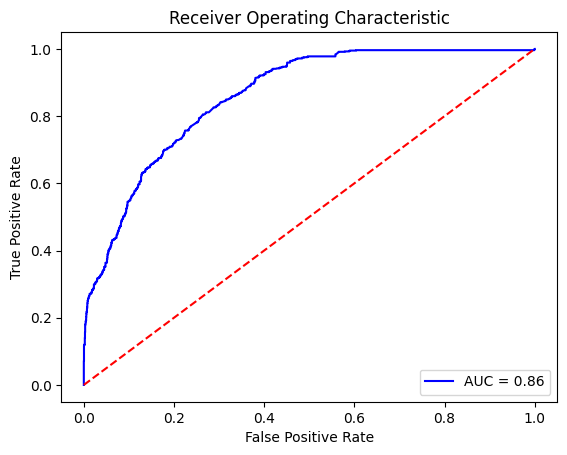

In [ ]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)
roc_auc(clf_gnb, X_test, y_test)

На следующем этапе сформируем датасет из результатов работы алгоритмов первого уровня.

In [ ]:
dataset_blender = pd.DataFrame(columns = ['knn', 'tree', 'bayes'])
X_knn = clf_knn.predict_proba(X_train)
dataset_blender['knn'] = X_knn[:,1].tolist()
X_tree = clf_tree.predict_proba(X_train)
dataset_blender['tree'] = X_tree[:,1].tolist()
X_bayes = clf_gnb.predict_proba(X_train)
dataset_blender['bayes'] = X_bayes[:,1].tolist()
dataset_blender['Finish'] = y_train.tolist()
dataset_blender = dataset_blender.set_index(X_train.index)
y_blender = dataset_blender['Finish']
dataset_blender.drop(['Finish'], axis=1, inplace=True)
dataset_blender

,knn,tree,bayes
user_id,,,
1390,0.000000,0.000000,0.014590
19402,0.000000,0.000298,0.007264
12478,0.000000,0.000000,0.011705
14990,0.034483,0.034483,0.280066
12891,0.000000,0.000298,0.007264
...,...,...,...
23499,0.724138,0.584906,0.428365
14410,0.000000,0.000000,0.007001
20822,0.000000,0.018182,0.016997


Подберем алгоритм второго уровня, который покажет наилучший результат по ROC-AUC-значению.

Разделим датасет на тренировочный и тестовый.

In [ ]:
X_blender_train, X_blender_test, y_blender_train, y_blender_test = train_test_split(dataset_blender, y_blender, test_size=0.2, stratify=y_blender, random_state=42)

Проведем подбор параметров для каждого варианта алгоритма.

In [ ]:
clf_knn_ensemble = KNeighborsClassifier()
knn_params = {'n_neighbors': range(1, 30), 'weights': ['uniform', 'distance'], 'p': [1,2,3], 'metric': ['euclidean', 'l1', 'l2', 'manhattan']}
gsCV_clf_knn = GridSearchCV(clf_knn_ensemble, knn_params, scoring='roc_auc', cv=5)
gsCV_clf_knn.fit(X_blender_train, y_blender_train)
print('Параметры ансамбля с алгоритмом knn', gsCV_clf_knn.best_params_)
print('Точность предсказания:', accuracy_score(y_blender_test, gsCV_clf_knn.predict(X_blender_test)))
print('ROC-AUC:', roc_auc_score(y_blender_test, gsCV_clf_knn.predict(X_blender_test)))

Параметры ансамбля с алгоритмом knn {'metric': 'euclidean', 'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}
Точность предсказания: 0.9017320607988688
ROC-AUC: 0.8161236058297168


Построим ROC-кривую для ансамбля с алгоритмом k-ближайших соседей с найденными оптимальными параметрами.

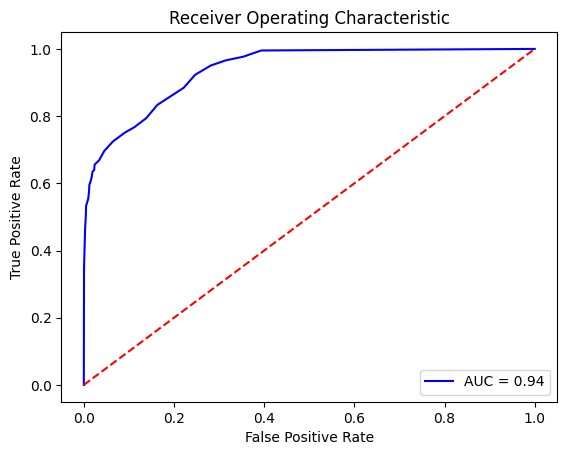

In [ ]:
clf_knn_blender = KNeighborsClassifier(metric='euclidean', n_neighbors=29, p=1, weights='uniform')
clf_knn_blender.fit(X_blender_train, y_blender_train)
roc_auc(clf_knn_blender, X_blender_test, y_blender_test)

In [ ]:
clf_tree_ensemble = tree.DecisionTreeClassifier()
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 23), 'min_samples_split': range(2,20,3), 'min_samples_leaf': range(1,51,3)}
gsCV_clf_tree = GridSearchCV(clf_tree_ensemble, tree_params, scoring='roc_auc', cv=5)
gsCV_clf_tree.fit(X_blender_train, y_blender_train)
print('Параметры ансамбля с алгоритмом дерева решений:', gsCV_clf_tree.best_params_)
print('Точность предсказания:', accuracy_score(y_blender_test, gsCV_clf_tree.predict(X_blender_test)))
print('ROC-AUC:', roc_auc_score(y_blender_test, gsCV_clf_tree.predict(X_blender_test)))

Параметры ансамбля с алгоритмом дерева решений: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 17}
Точность предсказания: 0.9066808059384942
ROC-AUC: 0.8236630808159342


Построим ROC-кривую для ансамбля с алгоритмом решающего дерева с найденными оптимальными параметрами.

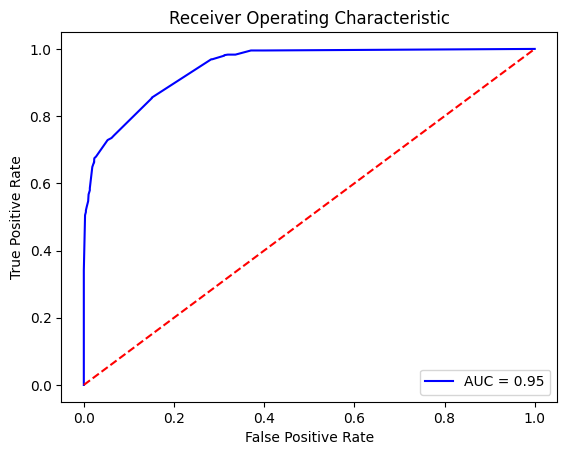

In [ ]:
clf_tree_ensemble = tree.DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_leaf=1, min_samples_split=17)
clf_tree_ensemble.fit(X_blender_train, y_blender_train)
roc_auc(clf_tree_ensemble, X_blender_test, y_blender_test)

In [ ]:
clf_gnb_ensemble = GaussianNB()
clf_gnb_ensemble.fit(X_blender_train, y_blender_train)
print('Точность предсказания ансамбля с алгоритмом Байесовского классификатора:', accuracy_score(y_blender_test, clf_gnb_ensemble.predict(X_blender_test)))
print('ROC-AUC:', roc_auc_score(y_blender_test, clf_gnb_ensemble.predict(X_blender_test)))

Точность предсказания ансамбля с алгоритмом Байесовского классификатора: 0.8702721809826794
ROC-AUC: 0.8162709743995702


Построим ROC-кривую для ансамбля с алгоритмом Байесовского классификатора.

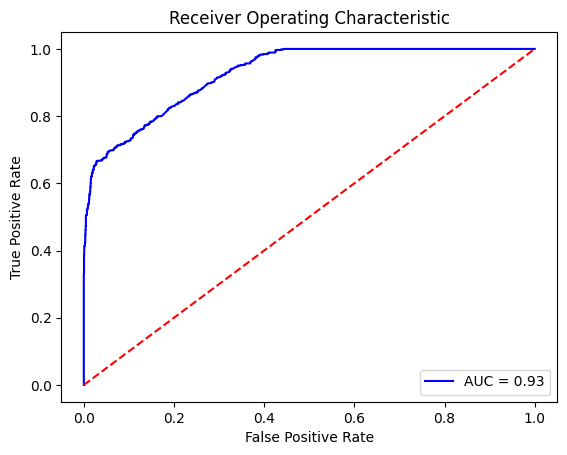

In [ ]:
clf_gnb_ensemble = GaussianNB()
clf_gnb_ensemble.fit(X_blender_train, y_blender_train)
roc_auc(clf_gnb_ensemble, X_blender_test, y_blender_test)

Рассмотрим таблицу с полученными значениями ROC-AUC по всем алгоритмам.

Алгоритм  | ROC-AUC
-------------------|--------------------
KNN       | 0.838
Решающее дерево       | 0.808
Байесовский классификатор       | 0.735
Ансамбль-KNN       | 0.829
Ансамбль-Решающее дерево       | 0.823
Ансамбль-Байесовский классификатор       | 0.817

Как мы видим наилучший результат показал алгоритм k-ближайших соседей. Выберем его в качестве основного алгоритма.

Реализуем класс Model для итоговой реализации модели.

Здесь представлены следующие методы:

1. init - Конструктор класса, где происходит загрузка датасетов, подготовка данных и обучение модели.
2. markup_dataset - метод разметки датасета на классы.
3. data_processing - метод обработки выбросов.
4. hampel - метод удаления выбросов с помощью фильтра Хэмпеля.
5. data_standartization - метод стандартизации данных.
6. train_model - метод тренировки модели.
7. predict - метод определения вероятности окончания курса пользователем.

In [ ]:
class Model():

    def __init__(self, path_action_train, path_status_train, path_action_predict, path_status_predict, period, point):
        self.user_step_action_train = pd.read_csv(path_action_train)
        self.user_step_status_train = pd.read_csv(path_status_train)
        self.user_step_action_predict = pd.read_csv(path_action_predict)
        self.user_step_status_predict = pd.read_csv(path_status_predict)
        self.period = period
        self.point_finish = point

        preparation_train = Preparation(path_action_train, path_status_train, self.period, self.point_finish)
        preparation_train.get_dataset()
        self.train_data = preparation_train.dataset
        self.train_data = self.markup_dataset(self.user_step_action_train, self.user_step_status_train, self.train_data)
        self.train_data = self.data_processing(self.train_data)

        preparation_test = Preparation(path_action_predict, path_status_predict, self.period, self.point_finish)
        preparation_test.get_dataset()
        self.predict_data = preparation_test.dataset
        self.predict_data = self.data_processing(self.predict_data)

        self.clf_knn = KNeighborsClassifier(metric='l1', n_neighbors=26, p=1, weights='distance')
        self.train_model()

        self.result = None

    def markup_dataset(self, user_step_action, user_step_status, dataset):
        max_timestamp = self.user_step_action_train['timestamp'].max()
        user_data = user_step_action.groupby('user_id', as_index=False).agg({'timestamp': 'max'})
        user_data = user_data.rename(columns={'timestamp': 'last_action'})
        user_data['user_time_drop'] = (max_timestamp - user_data.last_action) > 60 * 24 * 60 * 60
        user_data = user_data.merge(user_step_status.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index(), on='user_id', how='outer')
        user_data = user_data.fillna(0)
        user_data = user_data.merge(user_step_action.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index(), on='user_id', how='outer')
        user_data['finished'] = user_data.passed > self.point_finish
        dataset = self.train_data.copy()
        dataset = dataset.merge(user_data[['user_id', 'finished', 'user_time_drop']], on='user_id', how='outer')
        dataset = dataset[~((dataset['finished'] == False) & (dataset['user_time_drop'] == False))]
        dataset = dataset.copy()
        dataset['Finish'] = (dataset['finished']).map(int)
        dataset = dataset.set_index(dataset['user_id'])
        dataset = dataset.drop(['user_id', 'finished',	'user_time_drop'], axis=1)
        return dataset

    def data_processing(self, dataset):
        indexes = dataset.index
        dataset.correct = self.hampel(dataset.correct)
        dataset.wrong = self.hampel(dataset.wrong)
        dataset.steps_attempts = self.hampel(dataset.steps_attempts)
        dataset.sum_event = self.hampel(dataset.sum_event)

        fill_knn = dataset.copy()
        scaler = StandardScaler()
        fill_knn = pd.DataFrame(scaler.fit_transform(fill_knn), columns = fill_knn.columns)

        inputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
        fill_knn = pd.DataFrame(inputer.fit_transform(fill_knn), columns =  fill_knn.columns)

        fill_knn = pd.DataFrame(scaler.inverse_transform(fill_knn), columns = fill_knn.columns)
        dataset = fill_knn.copy()
        dataset['days'] = dataset['days'].map(int)
        dataset['correct'] = dataset['correct'].map(int)
        dataset['wrong'] = dataset['wrong'].map(int)
        dataset['steps_attempts'] = dataset['steps_attempts'].map(int)
        dataset['sum_event'] = dataset['sum_event'].map(int)
        if 'Finish' in dataset:
          dataset['Finish'] = dataset['Finish'].map(int)
        dataset.to_csv('train_dataset.csv')

        dataset = dataset.set_index(indexes)
        return dataset

    def hampel(self, vals_orig):
        vals = vals_orig.copy()
        difference = np.abs(vals.median()-vals)
        median_abs_deviation = difference.median()
        threshold = 3 * median_abs_deviation
        outlier_idx = difference > threshold
        vals[outlier_idx] = np.nan
        return(vals)

    def data_standartization(self, dataset):
      indexes = dataset.index
      scaler = StandardScaler()
      scaled = scaler.fit_transform(dataset)
      scaled = scaler.transform(dataset)
      X_scaled = pd.DataFrame(scaled, columns=dataset.columns)
      X_scaled = X_scaled.set_index(indexes)
      return X_scaled

    def train_model(self):
      y = self.train_data['Finish']
      X = self.train_data.copy()
      X.drop(['Finish'], axis=1, inplace=True)
      X_scaled = self.data_standartization(X)
      self.clf_knn.fit(X_scaled, y)

    def predict(self):
      X_scaled_predict = self.data_standartization(self.predict_data)
      self.result = self.clf_knn.predict_proba(X_scaled_predict)

Подготовим данные для проверки работы модели. Разделим данные на тренировочную выборку и выборку для определения степени успешности завершения курса пользователем.

In [ ]:
user_step_action = pd.read_csv('user_step_action.csv')
user_step_status = pd.read_csv('user_step_status.csv')

user_step_action_arr = user_step_action['user_id'].unique()
user_step_status_arr = user_step_action['user_id'].unique()

user_step_action_arr_train = user_step_action_arr[:15387]
user_step_status_arr_train = user_step_status_arr[:15387]
user_step_action_arr_test = user_step_action_arr[15387:]
user_step_status_arr_test = user_step_status_arr[15387:]

user_step_action_train_mask = user_step_action['user_id'].isin(user_step_action_arr_train)
user_step_status_train_mask = user_step_status['user_id'].isin(user_step_status_arr_train)
user_step_action_test_mask = user_step_action['user_id'].isin(user_step_action_arr_test)
user_step_status_test_mask = user_step_status['user_id'].isin(user_step_status_arr_test)

user_step_action_train = user_step_action[user_step_action_train_mask]
user_step_status_train = user_step_status[user_step_status_train_mask]
user_step_action_test = user_step_action[user_step_action_test_mask]
user_step_status_test = user_step_status[user_step_status_test_mask]

user_step_action_train.to_csv('user_step_action_train')
user_step_status_train.to_csv('user_step_status_train')
user_step_action_test.to_csv('user_step_action_test')
user_step_status_test.to_csv('user_step_status_test')

Получаем массив вероятностей отнесения пользователя к классу '0'(пользователь не закончит курс) и к классу '1'(пользователь закончит курс)

In [ ]:
model = Model('user_step_action_train', 'user_step_status_train', 'user_step_action_test', 'user_step_status_test', 2, 50)
model.predict()
model.result

array([[0.72282214, 0.27717786],
       [0.91309839, 0.08690161],
       [0.91309839, 0.08690161],
       ...,
       [0.96001474, 0.03998526],
       [0.91309839, 0.08690161],
       [0.80670124, 0.19329876]])

# Оценка модели и результатов

Для построения модели были осуществлены следующие этапы:
1. Подоготовлены данные. Из изначальных данных были получены следующие характеристики: количество уникальных дней,
количество верных и неверных решений, количество уникальных степов пользователя, доля верных решений, колличество действий пользователя за период.
Также были определены критерии того закончит ли пользователь курс или нет, и исходя из этих критерий был размечен датасет на классы для обчуения модели.
Далее были обработаны выбросы и пропущенные значения.
2. Исследованы различные алгоритмы классификации, а также были построены ансамбли из нескольких алогритмов. В итоге был выбран алгоритм k-ближайшах соседей(KNN),
так как он показал наилучший результат по ROC-AUC-значению.
3. Была построена итоговая модель, которая готова к анализу реальных данных.

В ходе разработки модели был выявлен алгоритм с наилучшим показателем ROC-AUC-значениея, им оказался алгоритм k-ближайших соседей(KNN).

Рассмотрим значения различных метрик, которые показывает данный алгоритм, а также построим ROC-AUC-кривую.

Точность предсказания: 0.8925643200452361
ROC-AUC: 0.8327956663376735
Метрика F1: 0.7246376811594203
Средняя точность: 0.6798463979087563


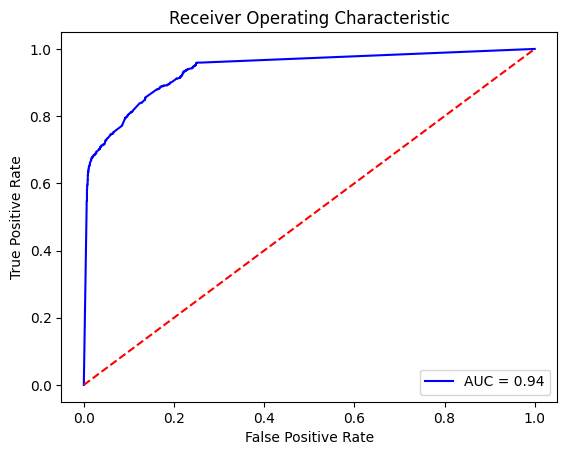

In [ ]:
clf_knn = KNeighborsClassifier(metric='l1', n_neighbors=26, p=1, weights='distance')
clf_knn.fit(X_train, y_train)
print('Точность предсказания:', accuracy_score(y_test, clf_tree.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, clf_knn.predict(X_test)))
print('Метрика F1:', f1_score(y_test, clf_tree.predict(X_test)))
print('Средняя точность:', average_precision_score(y_test, clf_knn.predict(X_test)))
roc_auc(clf_knn, X_test, y_test)

Можно сделать вывод, что данная модель демонстрирует достаточно хорошие результаты по различным метрикам и может использоваться
для определения вероятности окончания пользователем онлайн-курса.